In [34]:
import torch
import random
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import Omniglot
import torchvision.transforms as transforms

In [2]:
class OmniglotFewShot(Dataset):
    def __init__(self, root, mode="train", transform=None, n_way=5, k_shots=5, n_query=5):
        super(OmniglotFewShot, self).__init__()
        self.root = root
        self.transform = transform
        self.n_way = n_way
        self.k_shots = k_shots
        self.n_query = n_query
        self.mode = mode
        self.data = Omniglot(root=self.root, download=True, background=True if self.mode == "train" else False, transform=self.transform)
        self.indices_by_class = self._create_indices_by_class()

    def _create_indices_by_class(self):
        indices_by_class = {}
        for idx, (_, label) in enumerate(self.data):
            if label not in indices_by_class:
                indices_by_class[label] = []
            indices_by_class[label].append(idx)
        return indices_by_class
    
    def __len__(self):
        return len(self.indices_by_class)
    
    def __getitem__(self, idx):
        support_set = []
        query_set = []
        selected_classes = np.random.choice(len(self.indices_by_class), self.n_way, replace=False)
        
        for class_idx in selected_classes:
            class_indices = self.indices_by_class[class_idx]
            selected_indices = np.random.choice(class_indices, self.k_shots + self.n_query, replace=False)
            support_indices = selected_indices[:self.k_shots]
            query_indices = selected_indices[self.k_shots:]
            
            support_set.extend([self.data[i][0] for i in support_indices])
            query_set.extend([self.data[i][0] for i in query_indices])
            
        support_set = torch.stack(support_set)
        query_set = torch.stack(query_set)
        
        return support_set, query_set


In [10]:
class RandomRotation90:
    def __call__(self, img):
        angle = random.choice([0, 90, 180, 270])
        return transforms.functional.rotate(img, angle)

In [11]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    RandomRotation90(),
    transforms.ToTensor()
])


In [12]:
train_dataset = OmniglotFewShot(root='./data', mode='train', transform=transform, n_way=60, k_shots=5, n_query=5)
test_dataset = OmniglotFewShot(root='./data', mode='test', transform=transform, n_way=5, k_shots=5, n_query=15)


Files already downloaded and verified


100%|██████████| 6462886/6462886 [00:01<00:00, 3326124.00it/s]


Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


In [13]:

train_loader = DataLoader(train_dataset,shuffle=True)
test_loader = DataLoader(test_dataset,shuffle=False)

In [14]:
a = next(iter(train_loader))

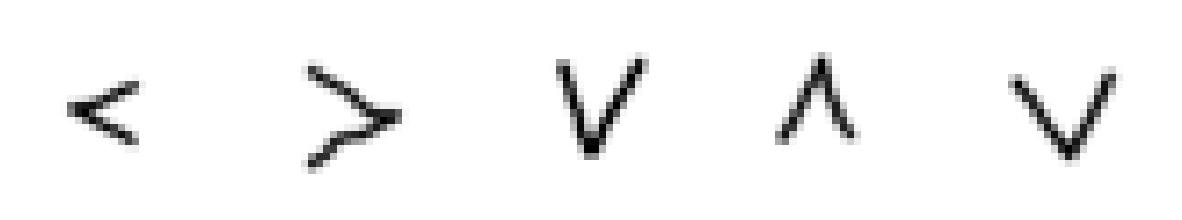

In [29]:
import matplotlib.pyplot as plt

def visualize_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i][0], cmap='gray')  
        ax.axis('off')
    plt.show()

visualize_images(a[0].squeeze(0), num_images=5)  

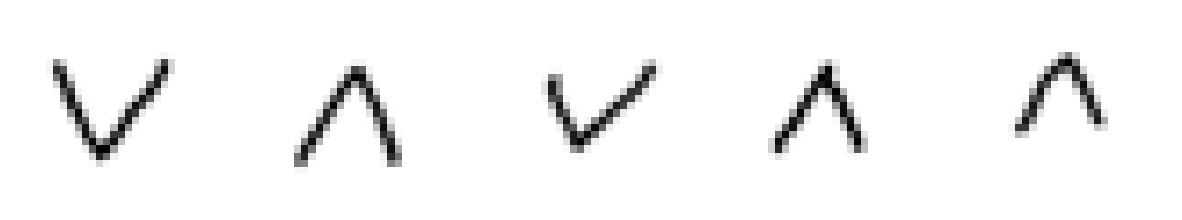

In [31]:
visualize_images(a[1].squeeze(0), num_images=5)

In [36]:
class Embedder(nn.Module):
    def __init__(self):
        super(Embedder, self).__init__()
        self.in_channels = 1
        self.out_channels = 64

        self.encoder = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        return x


In [37]:
Embedder = Embedder()

In [39]:
x = Embedder(a[0].squeeze(0))

In [40]:
x.shape

torch.Size([300, 64])